<h1 align="center"> Unlearnable Dataset</h1>
<h4 align="center"> Competition 04 </h4>
<h4 align="center"> Team name: 讓我活下來 </h4>
<h4 align="center"> Members: 李泓緯、林孟萱、陳隆琦、陳家惠 </h4>

<div class="alert alert-block alert-info">
<b><font size="4">Info:</font></b> <font size="3">In this competition, we have to crack the unlearnable dataset which proposed by Neural Tangent Generalization Attacks (NTGA) ICML'21. NTGA declines the generalization ability sharply, i.e. 99% -> 15%, 92% -> 33%, 99% -> 72% on MNIST, CIFAR10 and 2- class ImageNet, respectively. Our goal is to improve the testing accuracy.</font>
</div>

# **Import Packages**

In [132]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

from tqdm import tqdm

import re
from IPython import display

import statistics
import cv2

In [133]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# **Training Data Preprocess**

 因為考慮到影像是加了特殊的 noise，才讓模型在學習上會的成效會不太好，故一開始我們考慮到使用 openCV 中的濾波函數來做影像平滑處理以減少影像上的噪點或者失真，進而讓我們的模型成效提升，最後我們選擇了兩種濾波方式 -- *雙邊濾波（bilateralFilter）、高斯濾波（GaussianBlur）*，其中這兩種濾波都是套用高斯分佈的公式得到的，雙邊濾波不光只有考慮畫素在空間中位置遠近程度，還考慮了畫素亮度相近程度的影響。

 經過我們最後的測試，我們有以下做法：
 - 在 ImageNet 這筆資料裡，我們主要使用了以下三種 dataset（雙邊濾波、高斯濾波、未處理），不過三個最後出來的成效都差不多，可能是在做這些模糊處理時，並不能將這些 noise 給過濾掉，或是我們在設計濾波函數的參數時沒有設計好
 - 在 CIFAR-10 這筆資料裡，我們不採用上面提到的濾波方法，只有使用額外生成的高斯 noise 加進影像裡，希望藉由這些 noise 來搗亂原本影像中的 noise（此處程式碼寫在 Data Augmentation 裡）

In [136]:
train = np.load('./dataset/x_train_imagenet_unlearn.npy')
val = np.load('./dataset/x_val_imagenet.npy')
test = np.load('./dataset/x_test_imagenet.npy')

In [142]:
def bilateralFilter(img):
    img = cv2.bilateralFilter(img,9,75,75)
    return img

def GaussianBlur(img):
    img = cv2.GaussianBlur(img, (5, 5), 0)
    return img

In [143]:
new_train = np.array([bilateralFilter(img) for img in train])
new_val = np.array([bilateralFilter(img) for img in val])
new_test = np.array([bilateralFilter(img) for img in test])

In [144]:
np.save('./processed/x_train_imagenet_bilateralFilter', new_train)
np.save('./processed/x_val_imagenet_bilateralFilter', new_val)
np.save('./processed/x_test_imagenet_bilateralFilter', new_test)

Text(0.5, 1.0, 'Bilateral Filter Image')

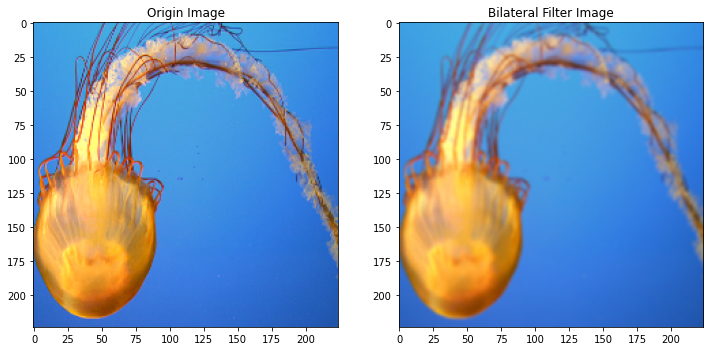

In [152]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(train[0])
plt.title('Origin Image')

plt.subplot(1, 2, 2)
plt.imshow(new_train[0])
plt.title('Bilateral Filter Image')

上圖左為原始影像，右為做過雙邊濾波處理的影像，可以看出影像變得較為模糊，有些圖片一時之間可能無法用肉眼做出判斷。

# **Import Data and Data Augmentation**

此處我們嘗試了以下幾種 data augmentation 的方式，包括上下左右翻轉、對比度及亮度的調整等，藉以提升我們在模型訓練的成效及穩健性，最後也是由實驗結果發現，對於做上下左右翻轉或是 90 度旋轉，並無法提升模型的成效，能來還會降低我們模型的效能，故後面的只有使用對比度及亮度的調整這些。

而在 CIFAR-10 上還有多做了前面提到的疊加額外生成的高斯 noise 。

## **Import Data**

In [163]:
x_train = np.load('./dataset/x_train_cifar10_unlearn.npy')
y_train = np.load('./dataset/y_train_cifar10.npy')
x_val = np.load('./dataset/x_val_cifar10.npy')
y_val = np.load('./dataset/y_val_cifar10.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [164]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

## **Data Augmentation**

In [153]:
# Augmentation parameter setting
up_down_flip_p = 0.4
left_right_flip_p = 0.4

noise_p = 0.7
rot_p = 0.5

crop_p = 0.5
brightness_p = 0.5
saturation_p = 0.5
contrast_p = 0.5

In [154]:
@tf.function
def gaussian_noise(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < noise_p:
        noise = tf.random.normal(image.shape, stddev=0.01)
        image = tf.math.add(image, noise)
        
    return image

@tf.function
def random_flip(image):
    up_down_outcome = tf.random.uniform([1], 0, 1)
    right_left_outcome = tf.random.uniform([1], 0, 1)

    if up_down_outcome<up_down_flip_p:
        image = tf.image.flip_up_down(image)

    if right_left_outcome<left_right_flip_p:
        image = tf.image.flip_left_right(image)

    return image

@tf.function
def random_rot90(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < (rot_p/2):
        image = tf.image.rot90(image)
    elif (prob >= (rot_p/2)) and (prob < rot_p):
        image = tf.image.rot90(image, k=2)   
        
    return image

@tf.function
def r_crop(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < crop_p:
        image = tf.image.resize(image, size=[IMAGE_HEIGHT + 5, IMAGE_WIDTH + 5])
        image = tf.image.random_crop(image, size=[IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    else:
        image = tf.image.resize(image, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
        
    return image

@tf.function
def brightness(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < brightness_p:
        image = tf.image.random_brightness(image, 0.5)
        
    return image

@tf.function
def saturation(image):
    prob = tf.random.uniform([1], 0, 1)
    
    if prob < saturation_p:
        image = tf.image.random_saturation(image, 0.85, 1.5)
        
    return image

@tf.function
def contrast(image):
    prob = tf.random.uniform([1], 0, 1)
    
    if prob < contrast_p:
        image = tf.image.random_contrast(image, 0.9, 2)
        
    return image

In [160]:
# data_preprocess for ImageNet
def data_preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    image = contrast(image)
    image = brightness(image)
    image = saturation(image)
    
#    image = random_flip(image)
#    image = random_rot90(image)
    image = gaussian_noise(image)

    return image, label

class dataset_generator():
    
    def __init__(self, image_path, label_path, batch_size):
        self.batch_size = batch_size
        
        image = np.load(image_path)
        self.image = image
        
        label = np.load(label_path)
        label = np.argmax(label, axis=1)
        self.label = label
        
    def generate(self, generate_func):
        dataset = tf.data.Dataset.from_tensor_slices((self.image, self.label))
        dataset = dataset.map(generate_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(1000)
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return dataset
    
# data_preprocess for CIFAR-10
def data_preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    image = contrast(image)
    image = brightness(image)
    image = saturation(image)
    
#    image = random_flip(image)
#    image = random_rot90(image)
#    image = gaussian_noise(image)

    return image, label

class dataset_generator():
    
    def __init__(self, image_path, label_path, batch_size):
        self.batch_size = batch_size
        
        image = np.load(image_path)
        gaussian = np.random.normal(0, 0.00001, (32, 32, 3)) 
        image = np.array([img + gaussian for img in image])
        self.image = image
        
        label = np.load(label_path)
        label = np.argmax(label, axis=1)
        self.label = label
        
    def generate(self, generate_func):
        dataset = tf.data.Dataset.from_tensor_slices((self.image, self.label))
        dataset = dataset.map(generate_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(1000)
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return dataset

In [156]:
# dataset_generator for ImageNet
x_train_path = './dataset/x_train_imagenet_unlearn.npy'
y_train_path = './dataset/y_train_imagenet.npy'
BATCH_SIZE = 64

ds_generator = dataset_generator(x_train_path, y_train_path, BATCH_SIZE)

dataset = ds_generator.generate(data_preprocess)

In [161]:
# dataset_generator for CIFAR-10
x_train_path = './dataset/x_train_cifar10_unlearn.npy'
y_train_path = './dataset/y_train_cifar10.npy'

ds_generator = dataset_generator(x_train_path, y_train_path, BATCH_SIZE)

dataset = ds_generator.generate(data_preprocess)

# **Model**

對於兩種模型，我們使用了相應不同的模型：

- 對於 ImageNet 資料，我們只使用了傳統的 CNN 模型，總共使用六層 convolution layer，我們也有發現模型用太多層或是少一點，對於結果成效並無太大影響
- 對於 CIFAR-10 資料，我們使用了 DenseNet201 和 DenseNet121 模型

## **Model for ImageNet**

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())
                
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())
                
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

## **Model for CIFAR-10**

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# 載入keras模型(更換輸出圖片尺寸)
model = DenseNet201(include_top=False,
                 weights='imagenet',
                 input_tensor=Input(shape=(32, 32, 3))
                 )

# 定義輸出層
x = model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# 載入keras模型(更換輸出圖片尺寸)
model = DenseNet121(include_top=False,
                 weights='imagenet',
                 input_tensor=Input(shape=(32, 32, 3))
                 )

# 定義輸出層
x = model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)

## **Training**

### **Training for ImageNet**

In [ ]:
optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint_filepath = './tmp_imagenet/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.fit(dataset, validation_data=batched_val_dataset, epochs=100, verbose=1, callbacks=[model_checkpoint_callback])

### **Training for CIFAR-10**

In [ ]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, 
              loss=loss_fn, 
              metrics=['accuracy'])

checkpoint_filepath = './tmp_cifar/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    
history = model.fit(x=batched_dataset, validation_data=batched_val_dataset, epochs=300, callbacks=[model_checkpoint_callback])

## **Predict on Testing Data**

### **Testing for ImageNet**

In [ ]:
x_test = np.load('./dataset/x_test_imagenet.npy')
model.load_weights(checkpoint_filepath)
y_test = model.predict(x_test)

In [ ]:
output = {
    'id': np.arange(len(x_test)),
    'label': np.array([1 if (x>0.5) else 0 for x in y_test])
}
y__test_pred = pd.DataFrame(data=output)
y__test_pred.to_csv('submission_imagenet.csv', index=False)

### **Testing for CIFAR-10**

In [ ]:
x_test = np.load('./dataset/x_test_cifar10.npy')
model.load_weights(checkpoint_filepath)
y_test = model.predict(x_test)

In [ ]:
output = {
    'id': np.arange(len(x_test)),
    'label': np.array([np.argmax(x) for x in y_test])
}
y__test_pred = pd.DataFrame(data=output)
y__test_pred.to_csv('submission_cifar10.csv', index=False)

# **Ensemble the Output**

對於兩種模型，我們對不同的結果做 ensemble：

- 對於 ImageNet 資料，我們取了採用雙邊濾波、高斯濾波和無處理的影像預測結果，挑選 accuracy 最高的來進行 ensemble
- 對於 CIFAR-10 資料，我們取了採用 DenseNet201 和 DenseNet121 模型的影像預測結果，挑選 accuracy 最高的來進行 ensemble

## **Ensemble for ImageNet**

In [ ]:
y__test_pred1 = pd.read_csv('./submission_imagenet_origin.csv')
y__test_pred2 = pd.read_csv('./submission_imagenet_bf.csv')
y__test_pred3 = pd.read_csv('./submission_imagenet_gb.csv')

response=[]

for i in range(y__test_pred1.shape[0]):
    
    most = statistics.mode([y__test_pred1['label'][i], 
                           y__test_pred2['label'][i], 
                           y__test_pred3['label'][i]])
    response.append(most)

In [ ]:
output_ensemble = {
    'id': np.arange(len(x_test)),
    'label': np.array([x for x in response])
    }

y__test_pred_ensemble = pd.DataFrame(data=output_ensemble)
y__test_pred_ensemble.to_csv('submission_ensemble_imagenet.csv', index=False)

## **Ensemble for CIFAR-10**

In [ ]:
y__test_pred1 = pd.read_csv('./submission_cifar_origin.csv')
y__test_pred2 = pd.read_csv('./submission_cifar_origin2.csv')
y__test_pred3 = pd.read_csv('./submission_cifar_origin3.csv')

response=[]

for i in range(y__test_pred1.shape[0]):
    
    most = statistics.mode([y__test_pred1['label'][i], 
                           y__test_pred2['label'][i], 
                           y__test_pred3['label'][i]])
    response.append(most)

In [ ]:
output_ensemble = {
    'id': np.arange(len(x_test)),
    'label': np.array([x for x in response])
    }

y__test_pred_ensemble = pd.DataFrame(data=output_ensemble)
y__test_pred_ensemble.to_csv('submission_ensemble_imagenet.csv', index=False)

***

# **Conclusion**

- **<font size="4">資料前處理（Data Preprocessing）</font>**
    - <font size="3"> 因為資料的特殊 noise，故我們有考慮了兩個方法，使用 openCV 的濾波函數和疊加額外高斯分佈生成的 noise，經過實驗，對於兩筆資料皆有使用不同的手法</font>
    - <font size="3"> 在前面敘述的兩種方法中，常常會遇到成效不佳的，導致無法完全消彌原本 noise 的影響，可能原因在於函數以及高斯分佈的參數選取，或許選取的好，就能夠提升模型的成效</font>
    - <font size="3"> 對於資料我們也有使用過去 data augmentation 的手法，最後也於實驗過後，決定只對影像進行對比度或亮度等的調整</font>
<br /><br />
- **<font size="4">模型建立與訓練（Model building and training）</font>**
    - <font size="3"> 在模型的選取上，我們對 ImageNet 使用簡單的 CNN 模型，而 CIFAR-10 則是使用 DenseNet 模型</font>
    - <font size="3"> 我們在訓練模型的過程中，會觀察到一個現象就是，不管模型過於複雜或是簡單，最後訓練出來的成效不會差很多，所以我們認為最後成績要高的關鍵在於前面的資料前處理</font>
<br /><br />
***